### Histograms and Medians from Differential Privacy

In this notebook we extend the basic building blocks to show how release histograms and an exponential mechanism for releasing medians.

We'll first build an algorithm for releasing DP medians by postprocessing a DP histogram:

Here are some previous functions we want to reuse:

In [1]:
import numpy as np
np.random.seed(1234)


def laplace(shift=0., scale=1., size=None):
    """Sample from the laplace distribution."""
    p = np.random.uniform(low=-0.5, high=0.5, size=size)
    draws = shift - scale * np.sign(p) * np.log(1 - 2 * abs(p))
    return draws

    # the easy way
    # return np.random.laplace(loc=shift, scale=scale, size=size)


def gaussian(shift=0., scale=1., size=None):
    """Sample from the Gaussian distribution."""
    draws = np.random.normal(loc=shift, scale=scale, size=size)
    return draws


def bernoulli(p, size=None):
    return np.random.uniform(size=size) < p


def discrete_laplace(loc, scale):
    if not scale:
        return loc
    alpha = np.exp(-1 / scale)

    noise = 0 if bernoulli(p=(1 - alpha) / (1 + alpha)) else np.random.geometric(1 - alpha)
    if bernoulli(p=0.5):
        noise *= -1
    return loc + noise


def cond_laplace(shift, scale):
    """Conditionally sample from laplace or discrete laplace depending on the dtype of `shift`"""
    if np.issubdtype(type(shift), np.integer):
        return discrete_laplace(shift, scale)
    if np.issubdtype(type(shift), np.float):
        return np.random.laplace(shift, scale)
    else:
        raise ValueError(f"unrecognized type {type(low)}")
    

def cond_uniform(low, high):
    """Conditionally sample from discrete or continuous uniform based on the dtype of `low`"""
    if np.issubdtype(type(low), np.integer):
        return low if low == high else np.random.randint(low, high)
    if np.issubdtype(type(low), np.float):
        return np.random.uniform(low, high)
    else:
        raise ValueError(f"unrecognized type {type(low)}")


def clamp(x, bounds):
    """Replace any x_i less than lower with lower, 
           and any x_i greater than upper with upper."""
    return np.clip(x, *bounds)


def bounded_mean(x, bounds):
    x_clamped = clamp(x, bounds)
    return np.mean(x_clamped)


def release_dp_mean(x, bounds, epsilon, delta=1e-6, mechanism="laplace"):
    """Release a DP mean. 
    Assumes that the dataset size n is public information.
    """
    sensitive_mean = bounded_mean(x, bounds)

    n = len(x)
    lower, upper = bounds
    # Sensitivity in terms of an absolute distance metric
    # Both the laplace and gaussian mechanisms can noise queries
    #    with sensitivities expressed in absolute distances
    sensitivity = (upper - lower) / n
    
    if mechanism == "laplace":
        scale = sensitivity / epsilon
        dp_mean = sensitive_mean + laplace(scale=scale)
    elif mechanism == "gaussian":
        scale = (sensitivity / epsilon) * np.sqrt(2*np.log(2/delta)) 
        dp_mean = sensitive_mean + gaussian(scale=scale)
    else:
        raise ValueError(f"unrecognized mechanism: {mechanism}")

    return dp_mean

    # the compact way
    # return laplace(shift=mean(x_clamped(x)), scale=(upper-lower)/(n*epsilon))
    # return gaussian(shift=mean(x_clamped(x)), scale=(upper-lower)/(n*epsilon))
    

def bootstrap(x, n):
    """Sample n values with replacement from n."""
    index = np.random.randint(low=0., high=len(x), size=n)
    return x[index]


Here is a DP Histogram function:

In [2]:
def release_dp_histogram(x, epsilon, categories):
    """Release an `epsilon`-DP estimate of the counts of each of the `categories`"""
    sensitivity = 2
    scale = sensitivity / epsilon

    # create a {category: count} hashmap
    counts = dict(zip(*np.unique(x, return_counts=True)))
    # look up the count of each category, or zero if not exists
    sensitive_histogram = np.array([counts.get(cat, 0) for cat in categories])

    dp_histogram = sensitive_histogram + laplace(scale=scale, size=sensitive_histogram.shape)
    return dp_histogram

Here is a DP Median estimator we can make post-processing a released DP Histogram:

In [3]:
def postprocess_quantile(categories, counts, q: float):
    """Postprocess a histogram release into a quantile estimate.

    :param categories: ordered data of length t
    :param counts: estimates of the counts of `categories`, of length t
    :param q: proportion of entries to the left, ranging from [0, 1]
    :return the category corresponding to the q-quantile of counts"""
    # approximate the cdf via `counts`
    cdf = np.cumsum(counts)
    cdf /= cdf[-1]

    return categories[np.argmax(cdf >= q)]


def release_dp_median_via_histogram(x, candidates, epsilon):
    # release a DP estimate of the histogram 
    dp_counts = release_dp_histogram(x, epsilon=epsilon, categories=candidates)

    # postprocess
    return postprocess_quantile(candidates, dp_counts, q=0.5)

We can also release DP medians via the exponential mechanism:

In [4]:
def discrete_exponential_mechanism(x, candidates, epsilon, scorer, sensitivity, monotonic=False):
    # score each candidate (can be more computationally efficient to score all at once)
    scores = np.array([scorer(x, candidate) for candidate in candidates])

    # for numerical stability; omitting this line results in the same probabilities
    scores -= scores.max()

    # compute likelihood of selecting each candidate
    epsilon /= 1 if monotonic else 2
    likelihoods = np.exp(epsilon * scores / sensitivity)

    # normalize to a probability
    probabilities = likelihoods / likelihoods.sum()

    # select one candidate wrt the selection probabilities
    return np.random.choice(a=candidates, p=probabilities)


def score_median(x, candidate):
    """Scores a candidate based on proximity to the median."""
    return min(sum(x <= candidate), sum(x >= candidate))


def release_dp_median_via_de(x, candidates, epsilon):
    """Release the dp median via the Discrete Exponential mechanism"""
    # sensitivity is 1 regardless of if input metric is Hamming or Symmetric
    return discrete_exponential_mechanism(x, candidates, epsilon,
        scorer=score_median, 
        sensitivity=1)


Read in the data. We are using the familiar PUMS dataset we are familiar with, and focusing on the education variable, a 16 point scale. This time we are being more formal with how we handle the data. Type inference itself might release the existence of `bb` in the data, so we handle this case explicitly.

Excerpt from [2005 PUMS Data Dictionary](https://www2.census.gov/programs-surveys/acs/tech_docs/pums/data_dict/PUMSDataDict05.pdf#page=28).

```
SCHL 2  
Educational attainment  

	bb .N/A (less than 3 years old)  
	01 .No school completed  
	02 .Nursery school to grade 4  
	03 .Grade 5 or grade 6  
	04 .Grade 7 or grade 8  
	05 .Grade 9  
	06 .Grade 10  
	07 .Grade 11  
	08 .Grade 12 no diploma  
	09 .High school graduate  
	10 .Some college, but less than 1 year  
	11 .One or more years of college, no degree  
	12 .Associate's degree  
	13 .Bachelor's degree  
	14 .Master's degree  
	15 .Professional school degree  
	16 .Doctorate degree
```

In [5]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv",
    # map 'bb' to 0 when parsing 'educ'
    converters={'educ': lambda v: 0 if v == 'bb' else int(v)})

# define public information
educ_levels = list(range(17))  # inferred from codebook excerpt
educ_bounds = (0, 16)

educ = data['educ'].values

Let's call the mechanisms we've developed here:

In [6]:
release_dp_histogram(educ, epsilon=1., categories=educ_levels)

array([-1.91923745e+00,  2.72560003e+02,  1.40733978e+02,  3.58691279e+02,
        4.70641741e+02,  4.95786741e+02,  7.55814947e+02,  8.95851391e+02,
        1.06496052e+03,  5.14978757e+03,  1.39533083e+03,  3.96400398e+03,
        1.15591434e+03,  6.28510818e+03,  2.26839914e+03,  7.95261111e+02,
        3.09012371e+02])

In [7]:
release_dp_median_via_histogram(
    educ, candidates=educ_levels, epsilon=0.5)

11

In [8]:
release_dp_median_via_de(
    educ, candidates=educ_levels, epsilon=0.5)

11

#### Show repeated releases on one sample of data

In [9]:
x = bootstrap(educ, 150)
n_sims = 100
epsilon = 0.4

history_hist = []
history_e_de = []
for i in range(n_sims):
	history_hist.append(release_dp_median_via_histogram(
		x=x, candidates=educ_levels, epsilon=epsilon))
	history_e_de.append(release_dp_median_via_de(
		x=x, candidates=educ_levels, epsilon=epsilon))

Now we'll compare.  We can see both give the correct median as the modal release, but the utility of the exponential mechanism is greater (lower chance of wrong answer, or MSE) than for the histogram based approach.

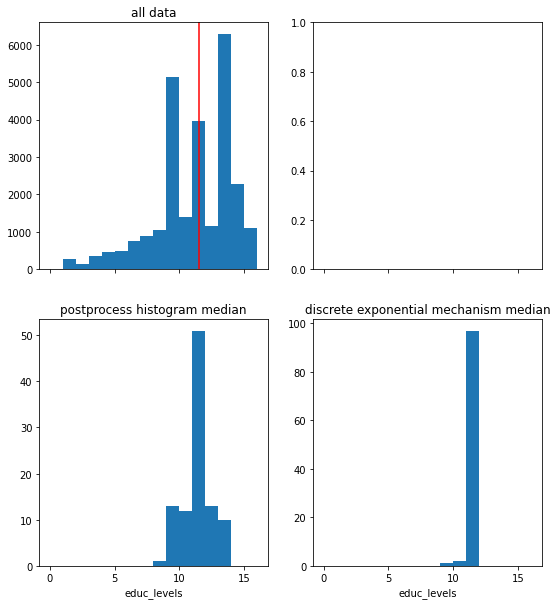

In [10]:
import matplotlib.pyplot as plt

fig, (
    (ax_data, _), 
    (ax_hist, ax_e_de)
) = plt.subplots(nrows=2, ncols=2, figsize=(9, 10), sharex=True)

ax_data.set_title("all data")
ax_data.hist(educ, bins=educ_levels)
# also show true sample median, centered in the bin
ax_data.axvline(x=np.median(x) + 0.5, color="r")

ax_hist.set_title("postprocess histogram median")
ax_hist.hist(history_hist, bins=educ_levels)

ax_e_de.set_title("discrete exponential mechanism median")
ax_e_de.hist(history_e_de, bins=educ_levels)

ax_hist.set_xlabel("educ_levels")
ax_e_de.set_xlabel("educ_levels")

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0df97151-1c38-49bc-a037-2a058b96fd82' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>